<a href="https://colab.research.google.com/github/girishvnair/Data-Analysis-Codes/blob/main/Bolt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
#import all required libaries
import pandas as pd
import numpy as np
from scipy import stats
from pandas.core.series import FillnaOptions
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns 
from sklearn import linear_model

In [149]:
#Load data from excel sheet
sales_data=pd.read_excel(r"Test.xlsx")

**Variables in the file:**
* order_id_new, order_try_id_new - id of an order
* calc_created- time when the order was created
* metered_price, distance, duration- actual price, distance and duration of a ride
* upfront_price- promised to the rider price, based on predicted duration (predicted_duration) and distance (predicted_distance)
* distance - ride distance
* duration - ride duration
* gps_confidence- indicator for good GPS connection (1 - good one, 0 - bad one)
* entered_by- who entered the address
* b_state- state of a ride (finished implies that the ride was actually done)
* dest_change_number- number of destination changes by a rider and a driver. It includes the original input of the destination by a rider. That is why the minimum value of it is 1
* predicted distance - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
* predicted duration - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
* prediction_price_type- internal variable for the type of prediction:
upfront, prediction - prediction happened before the ride upfront_destination_changed - prediction happened after rider changed destination during the ride
* change_reason_pricing - indicates whose action triggered a change in the price prediction. If it is empty, it means that either nobody changed the destination or that the change has not affected the predicted price
* ticket_id_new - id for customer support ticket
device_token, device_token_new - id for a device_token (empty for all the fields)
* rider_app_version - app version of rider phone
* driver_app_version- app version of driver phone
* driver_device_uid_new - id for UID of a phone device
* device_name- the name of the phone
* eu_indicator- whether a ride happens in EU
* overpaid_ride_ticket- indicator for a rider complaining about the overpaid ride
* fraud_score- fraud score of a rider. The higher it is the more likely the rider will cheat.

In [150]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id_new           4943 non-null   float64       
 1   order_try_id_new       4943 non-null   float64       
 2   calc_created           4943 non-null   datetime64[ns]
 3   metered_price          4923 non-null   float64       
 4   upfront_price          3409 non-null   float64       
 5   distance               4943 non-null   float64       
 6   duration               4943 non-null   float64       
 7   gps_confidence         4943 non-null   float64       
 8   entered_by             4943 non-null   object        
 9   b_state                4943 non-null   object        
 10  dest_change_number     4943 non-null   float64       
 11  prediction_price_type  4923 non-null   object        
 12  predicted_distance     4923 non-null   float64       
 13  pre

In [151]:
#View the data
sales_data.head(5)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22.0,22.0,2020-02-02 03:37:30.573,4.04,10.0,2839.0,700.0,1.0,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596.0,Xiaomi Redmi 6,1.0,0.0,-1383.0
1,618.0,618.0,2020-02-08 02:26:18.924,6.09,3.6,5698.0,493.0,1.0,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578.0,Samsung SM-G965F,1.0,0.0,NaN
2,657.0,657.0,2020-02-08 11:50:35.423,4.32,3.5,4426.0,695.0,1.0,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951.0,Samsung SM-A530F,1.0,0.0,-166.0
3,313.0,313.0,2020-02-05 06:34:53.782,72871.72,NaN,49748.0,1400.0,0.0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587.0,TECNO-Y6,0.0,1.0,NaN
4,1176.0,1176.0,2020-02-13 17:31:23.996,20032.50,19500.0,10273.0,5067.0,1.0,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433.0,Itel W5504,0.0,0.0,NaN


In [152]:
#Delete Unwanted columns (the ones are not available at the time of ride starting or doesnot add value)
sales_data = sales_data.drop(['entered_by','b_state','ticket_id_new','device_token','order_state','driver_device_uid_new','device_name','driver_app_version','rider_app_version','order_try_id_new','order_id_new','order_try_state','change_reason_pricing'],axis=1)

In [153]:
#Extract Day and part of day from timestamp
sales_data['Day']=sales_data['calc_created'].dt.day_name()
#Ordinal Label Encoding day of the week
week_day_dict = {
    'Sunday':0,
    'Monday':1,
    'Tuesday' : 2,
    'Wednesday' : 3,
    'Thursday' : 4,
    'Friday' : 5,
    'Saturday' :6
}
sales_data['day'] = sales_data['Day'].replace(week_day_dict)

In [154]:
#Extract and encode part of the day
sales_data['period'] = (sales_data['calc_created'].dt.hour % 24 + 4) // 4
sales_data['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)
part_of_day = {
    'Late Night':0,
    'Early Morning':1,
    'Morning' : 2,
    'Noon' : 3,
    'Evening' : 4,
    'Night' : 5,
    }
sales_data['part_of_day'] = sales_data['period'].replace(part_of_day)

In [155]:
#Encoding prediction price type
pred_type = {
    'prediction':0,
    'upfront':1,
    'upfront_destination_changed' : 2,
    'upfront_waypoint_changed' : 3,
    }
sales_data['prediction_price_type'] = sales_data['prediction_price_type'].replace(pred_type)

In [156]:
#Cleanup unwanted columns again
sales_data = sales_data.drop(['calc_created','Day','period'],axis=1)

In [157]:
#Delete duplicate data
sales_data = sales_data.drop_duplicates(keep='first')

In [158]:
# Columns prediction_price_type, predicted_distance, predicted_duration   are equally missing some data. Deleting those rows
sales_data=sales_data[sales_data['prediction_price_type'].notna()]

In [159]:
#dropping null cells of upfront_price
sales_data=sales_data[sales_data['upfront_price'].notna()]

In [160]:
#Find statistics of data
sales_data.describe()

,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,eu_indicator,overpaid_ride_ticket,fraud_score,day,part_of_day
count,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.0,2984.000000,2984.000000,2984.000000,2984.000000,1753.000000,2984.000000,2984.000000
mean,4483.871753,3871.078016,8965.017426,1218.427949,0.897453,1.064008,1.0,8485.447386,1002.204424,0.763405,0.033177,-695.130063,3.178954,2.794906
std,13433.711363,17710.937763,9997.280282,1257.869853,0.303417,0.367455,0.0,11475.116791,817.734028,0.425063,0.179128,1150.004601,2.057865,1.604185
min,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.0,21.000000,2.000000,0.000000,0.000000,-14225.000000,0.000000,0.000000
25%,4.440000,4.100000,3701.000000,543.000000,1.000000,1.000000,1.0,3893.000000,554.000000,1.000000,0.000000,-860.000000,1.000000,2.000000
50%,7.170000,6.500000,6533.500000,891.000000,1.000000,1.000000,1.0,6360.500000,836.000000,1.000000,0.000000,-286.000000,3.000000,3.000000
75%,22.505000,19.575000,11114.500000,1423.500000,1.000000,1.000000,1.0,10206.250000,1224.500000,1.000000,0.000000,-70.000000,5.000000,4.000000
max,194483.520000,595000.000000,171119.000000,18734.000000,1.000000,7.000000,1.0,353538.000000,20992.000000,1.000000,1.000000,49.000000,6.000000,5.000000


In [161]:
#Replace null values of fraud_score with mean
sales_data['fraud_score'].fillna(sales_data.fraud_score.mean(), inplace=True)

In [162]:
#Outlier detection

def outlier_detect(df, columns):
    for i in columns:
        Q1=df.describe().at['25%',i]
        Q3=df.describe().at['75%',i]
        IQR=Q3 - Q1
        LTV=Q1 - 1.5 * IQR
        UTV=Q3 + 1.5 * IQR
        x=np.array(df[i])
        p=[]
        for j in x:
            if j < LTV or j>UTV:
                p.append(df[i].median())
            else:
                p.append(j)
        df[i]=p
    return df
coloumns={'upfront_price','metered_price', 'distance', 'duration', 'predicted_distance','predicted_duration','dest_change_number','fraud_score' }
sales_data=outlier_detect(sales_data,coloumns)

In [163]:
#Find Correlation between features
sales_data.corr()

,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,eu_indicator,overpaid_ride_ticket,fraud_score,day,part_of_day
metered_price,1.000000,0.856404,0.463437,0.539499,-0.051973,NaN,NaN,0.419160,0.502485,-0.021639,0.018895,0.050101,0.021436,-0.004604
upfront_price,0.856404,1.000000,0.417630,0.443961,-0.038183,NaN,NaN,0.490578,0.581036,-0.016002,0.000413,0.060207,0.002974,0.012247
distance,0.463437,0.417630,1.000000,0.584970,-0.147389,NaN,NaN,0.665160,0.517420,-0.057286,0.029257,0.042844,-0.001542,0.015847
duration,0.539499,0.443961,0.584970,1.000000,-0.114877,NaN,NaN,0.428377,0.570013,-0.149050,0.061307,-0.000093,0.008742,0.007378
gps_confidence,-0.051973,-0.038183,-0.147389,-0.114877,1.000000,NaN,NaN,-0.158193,-0.175529,0.430446,-0.202605,0.115904,0.066446,-0.020496
dest_change_number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prediction_price_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
predicted_distance,0.419160,0.490578,0.665160,0.428377,-0.158193,NaN,NaN,1.000000,0.702649,-0.173725,0.038305,0.007715,-0.030421,0.036990
predicted_duration,0.502485,0.581036,0.517420,0.570013,-0.175529,NaN,NaN,0.702649,1.000000,-0.296637,0.071724,-0.043899,-0.036825,0.023752
eu_indicator,-0.021639,-0.016002,-0.057286,-0.149050,0.430446,NaN,NaN,-0.173725,-0.296637,1.000000,-0.293126,0.300281,0.107056,-0.046113


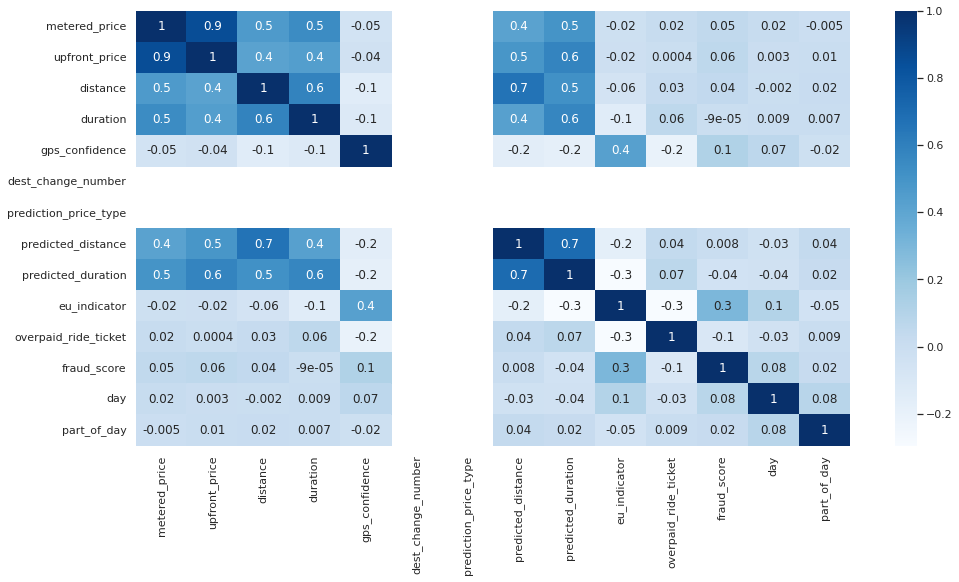

In [164]:
plt.figure(figsize=(16,8))
sns.set_theme(style="white")
corr = sales_data.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [165]:
#Dropping columns of lesser Correlation
sales_data = sales_data.drop(['dest_change_number','prediction_price_type','eu_indicator','overpaid_ride_ticket','fraud_score','day','part_of_day','gps_confidence'],axis=1)

# Here we can see that;
* Upfront price has strong correlation with metered price
* Predicted distance,  has lesser correlation with metered price than actual distance and actual duration. If we can predict distance more accurately we can improve the accuracy of upfront price.

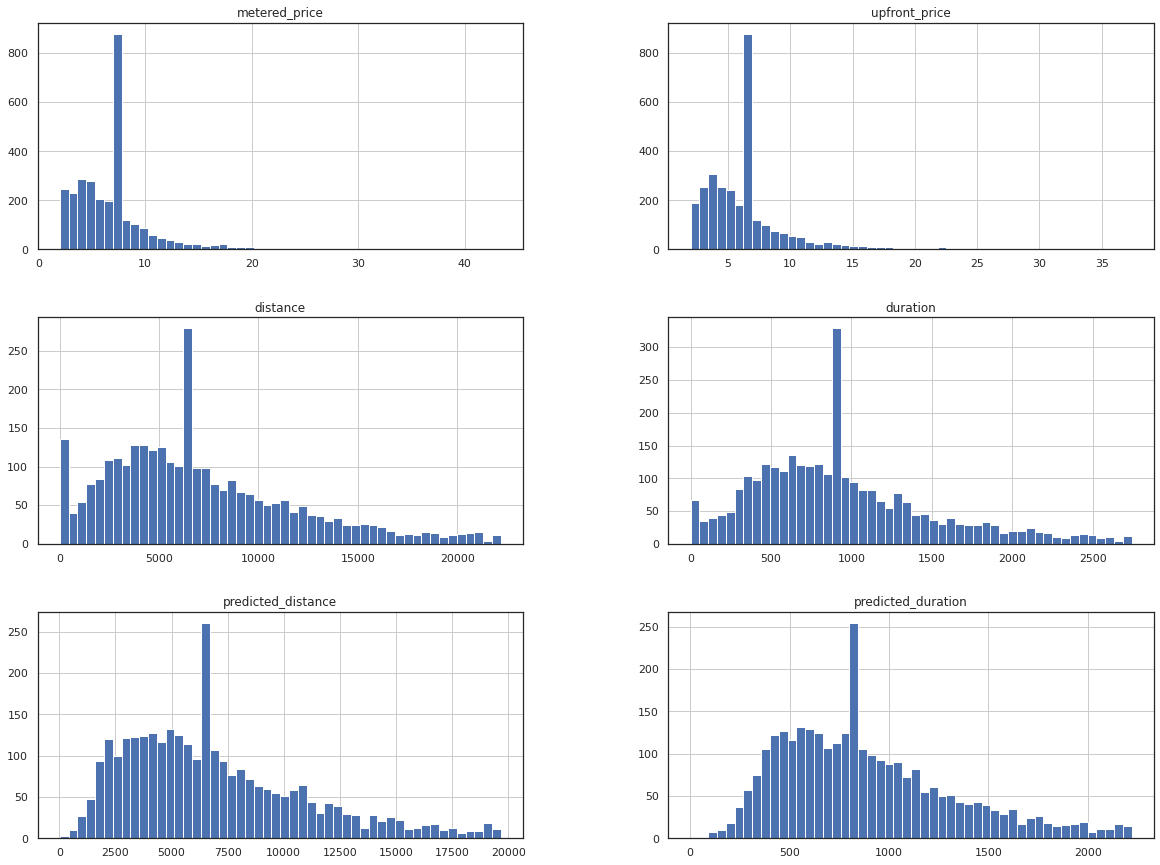

In [166]:
#Data distribution analysis
%matplotlib inline
sales_data.hist(bins=50,figsize=(20,15))
plt.show()

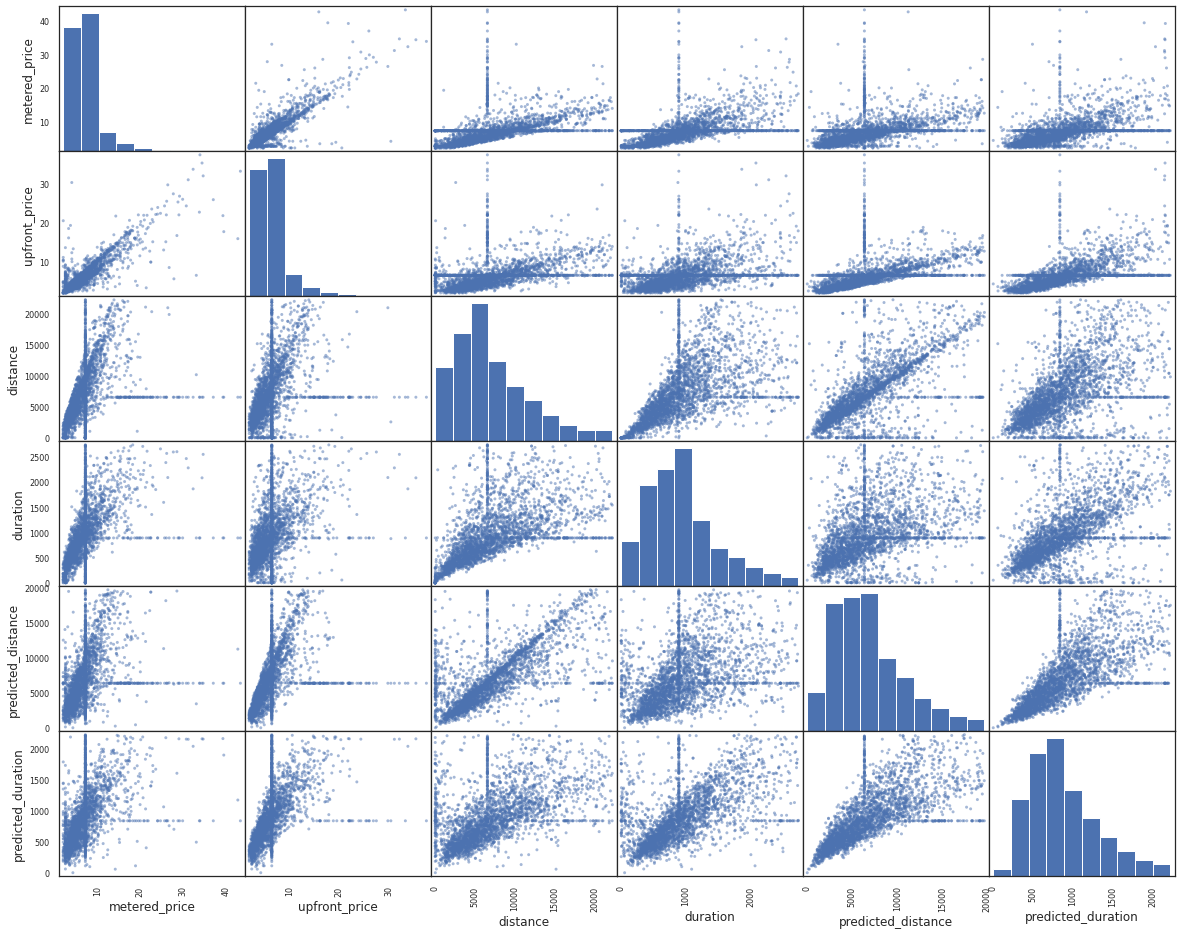

In [167]:
features = ['metered_price', 'upfront_price','distance','duration','predicted_distance', 'predicted_duration' ]
  
# plotting the scatter matrix
# with the features
scatter_matrix(sales_data[features], figsize=(20,16))
plt.show()

Here , we can see strong correlation between different features.
Actual distance and Actual duration will not be known at the time of upfront price calculation. They have strong correlation with predicted distance and predicted duration. Hence we can drop those two features which are redundant information

In [168]:
sales_data = sales_data.drop(['distance','duration'],axis=1)

In [169]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [170]:
#Target variable is upfront_price and prediction is based on predicted distance and predicted duration
X, y = sales_data.drop(['metered_price'],axis=1), sales_data.iloc[:,0]

In [171]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [172]:
print(X)

      upfront_price  predicted_distance  predicted_duration
0              10.0             13384.0              1091.0
1               3.6              2286.0               360.0
2               3.5              4101.0               433.0
4               6.5             14236.0               836.0
5               6.3              4882.0               562.0
...             ...                 ...                 ...
4936            3.2              3093.0               466.0
4937            5.6              9022.0              1029.0
4938           13.7             16172.0              1691.0
4940            7.4              5141.0               498.0
4941            8.1              8143.0               768.0

[2984 rows x 3 columns]


In [173]:
print(y)

0        4.04
1        6.09
2        4.32
4        7.17
5        6.11
        ...  
4936     3.31
4937     7.01
4938    10.89
4940     7.50
4941     3.06
Name: metered_price, Length: 2984, dtype: float64


In [174]:
sales_data

,metered_price,upfront_price,predicted_distance,predicted_duration
0,4.04,10.0,13384.0,1091.0
1,6.09,3.6,2286.0,360.0
2,4.32,3.5,4101.0,433.0
4,7.17,6.5,14236.0,836.0
5,6.11,6.3,4882.0,562.0
...,...,...,...,...
4936,3.31,3.2,3093.0,466.0
4937,7.01,5.6,9022.0,1029.0
4938,10.89,13.7,16172.0,1691.0
4940,7.50,7.4,5141.0,498.0


# **Regression Analysis with XGBoost and Linear Regression **

In [175]:
#XGBoost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [176]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', verbosity = 0, colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [177]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [178]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.824107


In [179]:
#kfold cross validation
params = {"objective":"reg:linear", "verbosity": 0,'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [180]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7.025117,0.024945,7.019531,0.063755
1,6.430834,0.030646,6.424386,0.111215
2,5.928070,0.038120,5.918002,0.164302
3,5.472138,0.048991,5.467220,0.169656
4,5.075852,0.058385,5.074044,0.219551


In [181]:
print((cv_results["test-rmse-mean"]).tail(1))

49    2.345739
Name: test-rmse-mean, dtype: float64


In [196]:
loss = np.sqrt(np.nanmean(np.square(((y_test - preds) / y_test))))*100
print("Error = {:0.2f} %".format(loss))

Error = 37.65 %


In [205]:
#Linear Regression
lrm=linear_model.LinearRegression()
lrm_model=lrm.fit(X_train,y_train)
lrm_predictions=lrm.predict(X_test)

Text(0, 0.5, 'Predicted')

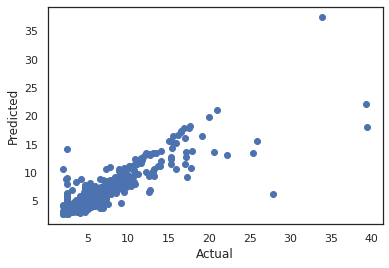

In [207]:
plt.scatter(y_test, lrm_predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [208]:
print('Score', lrm_model.score(X_test,y_test))

Score 0.7208407558626279


In [209]:
rmse = np.sqrt(mean_squared_error(y_test, lrm_predictions))
print("RMSE: %f" % (rmse))

RMSE: 2.224673


Linear Regression gives slightly better results compared to 
XGBoost